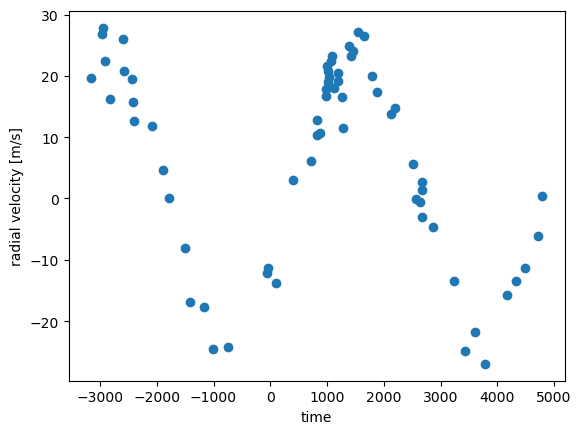

In [1]:
import emcee # pip install emcee
import numpy as np
import csv
import matplotlib.pyplot as plt
#https://rebound.readthedocs.io/en/latest/ipython_examples/RadialVelocity/

with open('test.csv') as f:
    cf = csv.reader(f)
    time = []
    rv = []
    for row in cf:
        time.append(float(row[0]))
        rv.append(float(row[1]))

fig, ax = plt.subplots(1,1)
ax.scatter(time, rv)
ax.set_xlabel("time")
ax.set_ylabel("radial velocity [m/s]")
plt.show()

In [2]:
import rebound
import emcee # pip install emcee
import corner # pip install corner
import numpy as np
import matplotlib.pyplot as plt

In [3]:
sim = rebound.Simulation()
sim.units = ["msun", "m", "s"] # Units of solar mass, meters, and seconds

In [5]:
sim.add(m=1) #star
sim.add(m=1e-3, P=21.0*60*60*24, h=0.1, k=0.05) 
sim.move_to_com()

/usr/local/anaconda3/lib/python3.11/site-packages/rebound/simulation.py:254: RuntimeWarning: No particles found. Will exit.
  warnings.warn(msg[1:], RuntimeWarning)


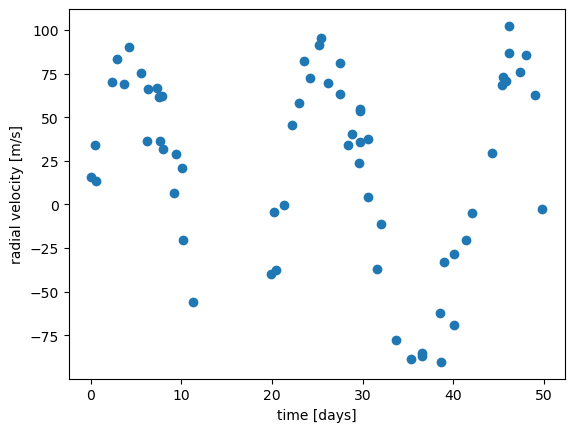

In [6]:
N=len(time)
# times = (np.array(time) - min(time))*500
# RVs = np.array(rv)
times = np.sort(50*60*60*24*np.random.random(N)) # 30 randomly spaced observations
RVs = np.zeros(N)
for i, t in enumerate(times):
    sim.integrate(times[i])
    RVs[i] = sim.particles[0].vx # radial velocity of the host star
RVs += np.random.normal(size=N, scale=20) # add 20m/s Gaussian noise

fig, ax = plt.subplots(1,1)
ax.set_xlabel("time [days]")
ax.set_ylabel("radial velocity [m/s]") 
ax.scatter(times/(24*60*60), RVs);

In [7]:
def setup_sim(params):
    P1, l1, h1, k1, m1 = params # unpack
    sim = rebound.Simulation()
    sim.units = ["msun", "m", "s"]
    sim.add(m=1)
    sim.add(m=m1, P=P1*60*60*24, h=h1, k=k1, l=l1)
    sim.move_to_com()
    return sim
def log_likelihood(params, times, RVs):
    ll = 0. # We use the log likelihood to avoid numerical issues with very small/large numbers
    sigma = 0 # We assume the error bars are 30 m/s for all observations
    sim = setup_sim(params)
    for i, t in enumerate(times):
        sim.integrate(times[i])
        deltaRV = sim.particles[0].vx - RVs[i]
        ll += -(deltaRV/sigma)**2
    return ll

In [8]:
ndim, nwalkers = 5, 20

# P1, l1, h1, k1, m1
ic = [20.0, 0.01, 0.01, 0.01, 1e-3] 
ic = np.tile(ic,(20,1)) # copy initial conditions for each walker
ic += 0.05*np.random.random((20,5))*ic # slightly perturb initial conditions

In [9]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood, args=[times, RVs])
state = sampler.run_mcmc(ic, 500)

/var/folders/1v/cd48h7k55jq4htqyxmr3x6wr0000gn/T/ipykernel_83786/3677498055.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  ll += -(deltaRV/sigma)**2
/usr/local/anaconda3/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]


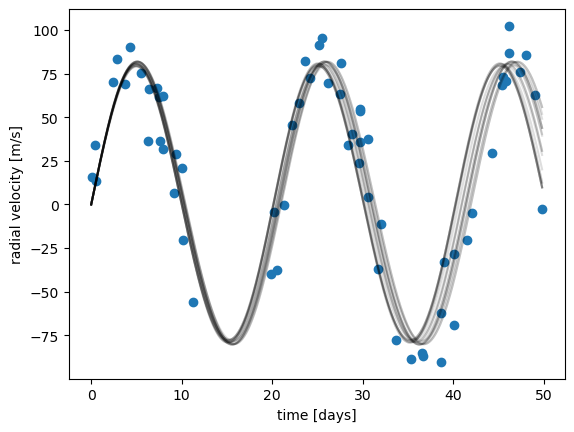

In [10]:
fig, ax = plt.subplots(1,1)
ax.set_xlabel("time [days]")
ax.set_ylabel("radial velocity [m/s]")

times_plot = np.linspace(0,times[-1],1000)
RVs_plot = np.zeros(len(times_plot))
Nplot = 20
indx = np.random.choice(7500, Nplot, replace=False)
for i in range(Nplot):
    s = setup_sim(sampler.flatchain[2500+indx[i]]) # skipping burn-in
    for j, t in enumerate(times_plot):
        s.integrate(t)
        RVs_plot[j] = s.particles[0].vx
    ax.plot(times_plot/(24*60*60), RVs_plot, color="black", alpha=0.13)
    
ax.scatter(times/(24*60*60), RVs);